In [ ]:
# | hide
%load_ext autoreload
%autoreload 2

# Tutorial

# Imports

In [ ]:
import os
from stringdale.diagrams import (
    Define,
    Scope,
    V,
    E,
    draw_diagram
)

from stringdale.core import  checkLogs
from stringdale.viz import draw_nx
import pytest
import asyncio


# Basic flow diagram
Diagrams consist of nodes and edges.

Nodes are defined using the V function.

Edges are defined using the E function.

We can define a diagram using nodes or edges.

The simplest diagram is a flow diagram. It consists of nodes and parallel edges: edges that are used to run multiple nodes in parallel.

There are 3 reserved node names:
* State: a node that is used to store and access state between node executions (see states section)
* Start: the start of the diagram
* End: the end of the diagram


## Defining a diagram
Let's define the simplest flow diagram using V - it doesn't do actions just runs nodes in parallel. 


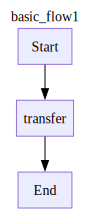

In [ ]:

with Define('basic_flow1',type='flow') as D:
    V('Start')
    V('End')
    V('transfer',inputs=['Start'],outputs=['End'])

We can define the same diagram using E.


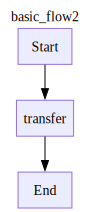

In [ ]:

with Define('basic_flow2',type='flow') as D:
    E('Start->transfer')
    E('transfer->End')

We can also print out a diagram without rendering it

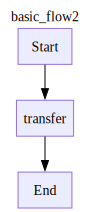

In [ ]:
draw_diagram(D)

## Running a diagram

We create an instance of diagram D to make sure we get a fresh copy of the diagram in cases where we want have multiple instances of the same diagram.

In [ ]:
d = D()

Run the diagram

In [ ]:
# Can run the whole diagram fom beginning to the end
print('Run the whole diagram fom beginning to the end:')
print(d.run_all(0))
# We can check if diagram got to the end    
print('Check if diagram got to the end:')
print(d.finished)
# We can check the output of the diagram
print('Check the output of the diagram:')
print(d.output)


Run the whole diagram fom beginning to the end:
0
Check if diagram got to the end:
True
Check the output of the diagram:
0


Usually we would want to run the diagram step by step to see what's happening. 

For that we use d.run() and print the trace
every node that is run will return a trace object.

This trace object contains the input and output of the node as well as some other useful information
we can use this trace to both debug the diagram.


We can print the trace to the user.

In [ ]:
print('Run the diagram step by step to see what\'s happening:')
for trace in d.run(0):
    trace.pprint()

Run the diagram step by step to see what's happening:
Node Start:
{'input': {0: 0}, 'output': 0}
Node transfer:
{'input': {0: 0}, 'output': 0}
Node End:
{'input': {0: 0}, 'output': 0}


Or we can save the trace to a file (logging)


In [ ]:
log_file = 'log.txt'
for trace in d.run(0):
    trace.pprint(file=log_file)

Let's take a look at the log file

In [ ]:
! cat log.txt
os.unlink(log_file)

Node Start:
{'input': {0: 0}, 'output': 0}
Node transfer:
{'input': {0: 0}, 'output': 0}
Node End:
{'input': {0: 0}, 'output': 0}


# Basic ports

Till now we have been using the default ports.

But we can also define custom ports for a node.

Note that the output_port of the Start node is passed to the input_port of the End node.

And the other port is discarded.

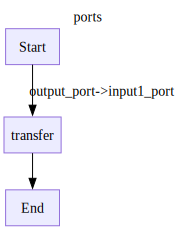

Node Start:
{ 'input': {'other_port': 2, 'output_port': 1},
  'output': {'other_port': 2, 'output_port': 1}}
Node transfer:
{'input': {'input1_port': 1}, 'output': {'input1_port': 1}}
Node End:
{'input': {0: {'input1_port': 1}}, 'output': {'input1_port': 1}}


In [ ]:
with Define('ports',type='flow') as D:
    E('Start->transfer(input1_port=output_port)')
   
    E('transfer->End')

d = D()

for trace in d.run({'output_port':1,'other_port':2}):

    trace.pprint()

We can also use the . notation to get the output of the previous node as one variable.

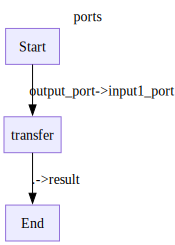

Node Start:
{ 'input': {'other_port': 2, 'output_port': 1},
  'output': {'other_port': 2, 'output_port': 1}}
Node transfer:
{'input': {'input1_port': 1}, 'output': {'input1_port': 1}}
Node End:
{ 'input': {'result': {'input1_port': 1}},
  'output': {'result': {'input1_port': 1}}}


In [ ]:
with Define('ports',type='flow') as D:
    E('Start->transfer(input1_port=output_port)')
   
    E('transfer->End(result =.)')

d = D()

for trace in d.run({'output_port':1,'other_port':2}):
    # note that the output_port of the Start node is passed to the input_port of the End node
    # the other port is discarded
    trace.pprint()

We can also use several ports to define multiple edges from the same node.

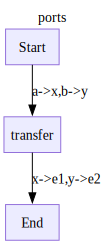

Node Start:
{'input': {'a': 1, 'b': 2}, 'output': {'a': 1, 'b': 2}}
Node transfer:
{'input': {'x': 1, 'y': 2}, 'output': {'x': 1, 'y': 2}}
Node End:
{'input': {'e1': 1, 'e2': 2}, 'output': {'e1': 1, 'e2': 2}}


In [ ]:
with Define('ports',type='flow') as D:
    E('Start->transfer(x=a, y=b)')
    # we use . to get all ports
    E('transfer->End(e1 = x, e2 = y)')

d = D()

for trace in d.run({'a':1,'b':2}):
    trace.pprint()

See the difference when we don't define the ports for the End node.

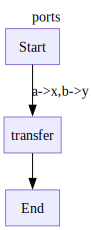

Node Start:
{'input': {'a': 1, 'b': 2}, 'output': {'a': 1, 'b': 2}}
Node transfer:
{'input': {'x': 1, 'y': 2}, 'output': {'x': 1, 'y': 2}}
Node End:
{'input': {0: {'x': 1, 'y': 2}}, 'output': {'x': 1, 'y': 2}}


In [ ]:
with Define('ports',type='flow') as D:
    E('Start->transfer(x=a, y=b)')
    E('transfer->End')

d = D()

for trace in d.run({'a':1,'b':2}):
    trace.pprint()

# Flow diagram with a function node

A node can have a function and perform some operations.

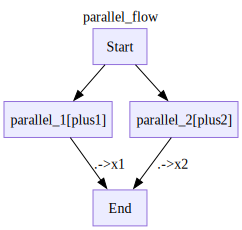

Node Start:
{'input': {0: 0}, 'output': 0}
Node parallel_2:
{'input': {0: 0}, 'output': 2}
Node parallel_1:
{'input': {0: 0}, 'output': 1}
Node End:
{'input': {'x1': 1, 'x2': 2}, 'output': {'x1': 1, 'x2': 2}}


In [ ]:
def plus1(x):
    return x + 1

def plus2(x):
    return x + 2

with Define('parallel_flow',type='flow') as ParallelD:
    V('Start')
    V('End')
    # x1 = . is a way to pass the output of the node to the x1 port End node
    V('parallel_1',plus1,inputs=['Start'],outputs=['End(x1 = .)'])
    V('parallel_2',plus2,inputs=['Start'],outputs=['End(x2 = .)'])

d = ParallelD()
for trace in d.run(0):
    trace.pprint()

# Flow diagram with a diagram node

We can use an existing diagram as a node. parallel_adder is a node that uses the ParallelD diagram we defined earlier.

See that trace has all the nodes from the ParallelD diagram (parallel_adder.Start, parallel_adder.parallel_1 etc)

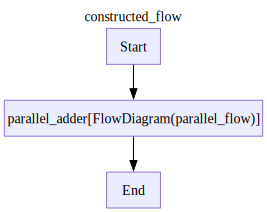

Node Start:
{'input': {0: 0}, 'output': 0}
Node parallel_adder.Start:
{'input': {0: 0}, 'output': 0}
Node parallel_adder.parallel_2:
{'input': {0: 0}, 'output': 2}
Node parallel_adder.parallel_1:
{'input': {0: 0}, 'output': 1}
Node parallel_adder.End:
{'input': {'x1': 1, 'x2': 2}, 'output': {'x1': 1, 'x2': 2}}
Node parallel_adder:
{'input': {0: 0}, 'output': {'x1': 1, 'x2': 2}}
Node End:
{'input': {0: {'x1': 1, 'x2': 2}}, 'output': {'x1': 1, 'x2': 2}}


In [ ]:
with Define('constructed_flow',type='flow') as D:
    V('Start')
    V('End')
    V('parallel_adder',ParallelD,inputs=['Start'],outputs=['End'])

d = D()
for trace in d.run(0):
    trace.pprint()


# Flow diagram with async functions    

We can use async functions in a flow diagram.

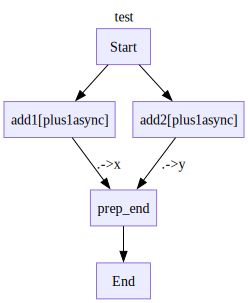

In [ ]:
async def plus1async(x,**kwargs):
    await asyncio.sleep(0.1)
    return x+1

# with checkLogs(name='__main__'):
with Define('test',type='flow') as D:

    V('add1',plus1async)
    V('add2',plus1async)
    V('Start',outputs=['add1','add2'])
    V('prep_end',inputs=['add1(x)','add2(y)'])
    E('prep_end->End')

In [ ]:
d = D()
for trace in d.run(1):
    trace.pprint()

assert d.output == {'x': 2, 'y': 2}
assert d.finished

Node Start:
{'input': {0: 1}, 'output': 1}
Node add2:
{'input': {0: 1}, 'output': 2}
Node add1:
{'input': {0: 1}, 'output': 2}
Node prep_end:
{'input': {'x': 2, 'y': 2}, 'output': {'x': 2, 'y': 2}}
Node End:
{'input': {0: {'x': 2, 'y': 2}}, 'output': {'x': 2, 'y': 2}}


# Ports - more


## Double splat (**) 
** is used to "expand" a dict into keyword arguments.

Sum node expects two arguments x and y. We unpack the output of the Parallel_end node into keyword arguments.


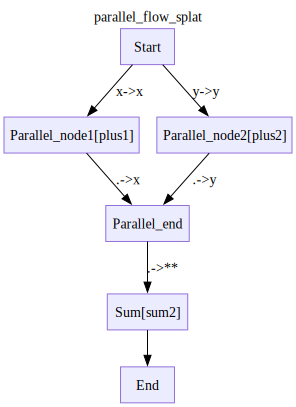

Node Start:
{'input': {'x': 1, 'y': 2}, 'output': {'x': 1, 'y': 2}}
Node Parallel_node2:
{'input': {'y': 2}, 'output': 4}
Node Parallel_node1:
{'input': {'x': 1}, 'output': 2}
Node Parallel_end:
{'input': {'x': 2, 'y': 4}, 'output': {'x': 2, 'y': 4}}
Node Sum:
{'input': {'x': 2, 'y': 4}, 'output': 6}
Node End:
{'input': {0: 6}, 'output': 6}


In [ ]:
def plus1(x):
    return x+1

def plus2(y):
    return y+2

def sum2(x,y):
    return x+y

with Define('parallel_flow_splat',type='flow') as ParallelDS:
    V('Start',
        outputs=['Parallel_node1(x=x)','Parallel_node2(y=y)']
        )
    V('Parallel_node1',plus1)
    V('Parallel_node2',plus2)
    E('Parallel_node1->Parallel_end(x=.)')
    E('Parallel_node2->Parallel_end(y=.)')
    V('Sum',sum2)
    E('Parallel_end->Sum(**)') 
    E('Sum->End')


d = ParallelDS()
for trace in d.run({'x':1,'y':2}):
    trace.pprint()

If we don't use double splat, the output of parallel end is passed as one argument to the Sum node.

We get an error because the sum function expects two arguments.


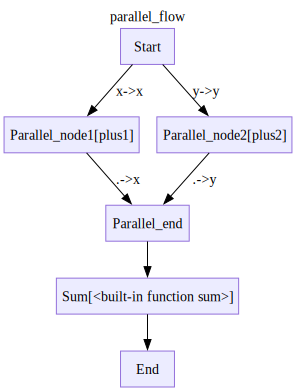

Node Start:
{'input': {'x': 1, 'y': 2}, 'output': {'x': 1, 'y': 2}}
Node Parallel_node1:
{'input': {'x': 1}, 'output': 2}
Node Parallel_node2:
{'input': {'y': 2}, 'output': 4}
Node Parallel_end:
{'input': {'x': 2, 'y': 4}, 'output': {'x': 2, 'y': 4}}
Error: When running node 'Sum[None]':
Function <built-in function sum>(args=[{'x': 2, 'y': 4}],kwargs={})
returned
Error 'unsupported operand type(s) for +: 'int' and 'str''



In [ ]:
with Define('parallel_flow',type='flow') as ParallelD:
    V('Start',
        outputs=['Parallel_node1(x=x)','Parallel_node2(y=y)']
        )
    V('Parallel_node1',plus1)
    V('Parallel_node2',plus2)
    E('Parallel_node1->Parallel_end(x=.)')
    E('Parallel_node2->Parallel_end(y=.)')
    V('Sum',sum)
    E('Parallel_end->Sum') 
    E('Sum->End')

d = ParallelD()
try:
    for trace in d.run({'x':1,'y':2}):
        trace.pprint()
except Exception as e:
    print(f"Error: {e}")


We can always explicitly pass the arguments to the Sum node.

But double splat is more convenient when there are many arguments.


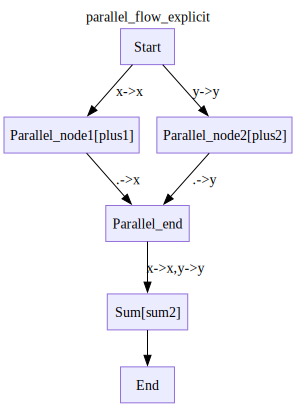

finished: True
output: 6


In [ ]:
with Define('parallel_flow_explicit',type='flow') as ParallelE:
    V('Start',
        outputs=['Parallel_node1(x=x)','Parallel_node2(y=y)']
        )
    V('Parallel_node1',plus1)
    V('Parallel_node2',plus2)
    E('Parallel_node1->Parallel_end(x=.)')
    E('Parallel_node2->Parallel_end(y=.)')
    V('Sum',sum2)
    E('Parallel_end->Sum(x=x,y=y)') 
    E('Sum->End')

d = ParallelE()
d.run_all({'x': 1,'y':2})
print( 'finished:', d.finished)
print( 'output:',d.output)


## Unnamed ports for discarding inputs
We can discard inputs that we don't need in the next node.

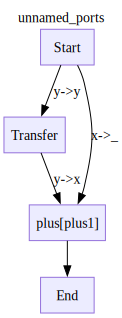

In [ ]:
def plus1(x):
    return x+1


with Define('unnamed_ports',type='flow') as D:
    E('Start->Transfer(y=y)')
    V('plus',plus1,
        inputs=[
        'Start(_=x)',
        'Transfer(x=y)'],
        outputs=['End']
        )



In [ ]:
d=D()
# with checkLogs(name='stringdale.diagrams.flow'):    
for trace in d.run({'x':1,'y':2}):
    trace.pprint()


Node Start:
{'input': {'x': 1, 'y': 2}, 'output': {'x': 1, 'y': 2}}
Node Transfer:
{'input': {'y': 2}, 'output': {'y': 2}}
Node plus:
{'input': {'x': 2}, 'output': 3}
Node End:
{'input': {0: 3}, 'output': 3}


# Decision diagrams

Decision diagrams allow you to create conditional flows in your graph where execution can take different paths based on conditions. Here are the key concepts:

1. **Conditional Edges**: Edges can have conditions attached to them using the `cond` parameter. When a condition is specified, the edge will only be followed if the condition evaluates to `True`.

2. **Default Edges**: Any edge without a condition acts as a default path. When no conditional edges evaluate to `True`, the flow follows the default edge.

3. **Rules**:
    - Each node that has outgoing conditional edges must have at least one default edge
    - All conditions on outgoing edges are evaluated in parallel
    - If more than one condition evaluates to `True`, an error is raised
    - For a given node, all incoming non-state edges must be of the same type (either all conditional or all non-conditional)
    - Similarly, all outgoing edges must be of the same type (either all conditional or all non-conditional)

Here's a simple example:

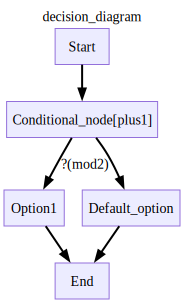

In [ ]:
def mod2(x):
    return x%2==0


with Define('decision_diagram') as DecisionD:
    V('Conditional_node',plus1)
    E('Start->Conditional_node')
    V('Option1')
    V('Default_option')
    # by default, all edges we define are conditional,
    # we can specify a condition for an edge by passing a function to the cond argument
    E('Conditional_node->Option1',cond=mod2)
    # not passing a condition means that this edge is the default edge
    # each node that has outgoing conditional edges must have at least one default edge
    E('Conditional_node->Default_option')
   
    E('Option1->End')

    E('Default_option->End')


d = DecisionD()


This should go to Option1 node


In [ ]:
for trace in d.run(1):
    trace.pprint()
    

Node Start:
{'input': {0: 1}, 'output': 1}
Node Conditional_node:
{'input': {0: 1}, 'output': 2}
Node Option1:
{'input': {0: 2}, 'output': 2}
Node End:
{'input': {0: 2}, 'output': 2}


This should go to Default_option node 


In [ ]:
for trace in d.run(0):
    trace.pprint()

Node Start:
{'input': {0: 0}, 'output': 0}
Node Conditional_node:
{'input': {0: 0}, 'output': 1}
Node Default_option:
{'input': {0: 1}, 'output': 1}
Node End:
{'input': {0: 1}, 'output': 1}


# Breaks

Breaks are a feature in stringdale that allow you to pause diagram execution and get new input from the user before continuing. Their main purpose is to create interactive flows where you can get user input at specific points in the execution.

- When execution reaches a break node, the diagram pauses and waits for new input.
- After receiving new input, execution continues from the break point.

- Breaks can be combined with conditional edges to create complex interactive flows




In [ ]:
# LLM dummy function
class MessageAdder():
    def __init__(self,to_add):
        self.to_add = to_add
    
    def __call__(self,**message):
        content = message.get('content',0)
        if isinstance(content,int):
            new_cont = content + self.to_add
        elif isinstance(content,str):
            new_cont = f'{content} _ '
        else:
            raise ValueError(f'content {content} must be an int or a string')
        return {'role':'adder','content':new_cont}
    
    def __str__(self):
        return f'MessageAdder({self.to_add})'

In this simple example a break happens only once per run if the condition is met.

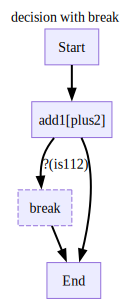

In [ ]:
with Define('decision with break') as D:

    def is112(x):
        return x == 112

    V('add1',plus2 ,inputs=['Start'],)
    V('break',is_break=True)
   
    E('add1->break',cond=is112)
    E('add1->End')
    E('break->End')


In [ ]:
d = D()


Run with input 100. The break is not met, so the diagram continues to the End node.

In [ ]:
print("Running with input 100:")
d.run_all(100)
print(f"d.finished: {d.finished}")


Running with input 100:
d.finished: True


Run with input 110. The break is met, so the diagram pauses and waits for new input. 


In [ ]:
print("Running with input 110:")
for trace in d.run(110):
    trace.pprint()

print(f"d.finished: {d.finished}")

Running with input 110:
Node Start:
{'input': {0: 110}, 'output': 110}
Node add1:
{'input': {0: 110}, 'output': 112}
d.finished: False


If run the diagram again, we see that it starts from the break node and continues to the End node.

In [ ]:
for trace in d.run(112):
    trace.pprint()


print(f"d.finished: {d.finished}")

Node break:
{'input': {0: 112}, 'output': 112}
Node End:
{'input': {0: 112}, 'output': 112}
d.finished: True


In this example we define a loop with a break condition. The diagram will continue looping and asking for the user input until the result of the add1 node equals 112, at which point it will exit the loop and proceed to the End node.


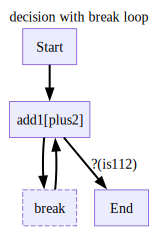

In [ ]:
with Define('decision with break loop') as D:

    def is112(x):
        return x == 112

    V('add1',plus2,inputs=['Start'],)
    V('break',is_break=True)
    
    E('add1->End',cond=is112)
    E('add1->break')
    E('break->add1')


It's a slightly different example. The condition is met when the input equals 112.


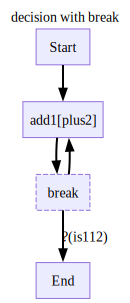

In [ ]:
with Define('decision with break') as D:

    def is112(x):
        return x == 112

    V('add1',plus2,inputs=['Start'],)
    V('break',is_break=True)
   
    E('add1->break')
    E('break->add1')
    E('break->End',cond=is112)


In [ ]:
d = D()

# Run with input 100
print("Running with input 100:")
d.run_all(100)
# After running with 100, we haven't reached the end condition (x == 112)
# so the diagram is not finished
assert d.finished == False
print(f"Finished: {d.finished}")

# Run with input 101
print("\nRunning with input 101:")
d.run_all(101)
# Still haven't reached the end condition
assert d.finished == False
print(f"Finished: {d.finished}")

# Run with input 110
print("\nRunning with input 110:")
d.run_all(112)
# After adding 2 to 110, we get 112, which satisfies our end condition
print(f"Finished: {d.finished}")



Running with input 100:
Finished: False

Running with input 101:
Finished: False

Running with input 110:
Finished: True


## Nested breaks


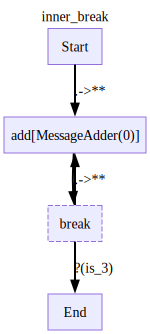

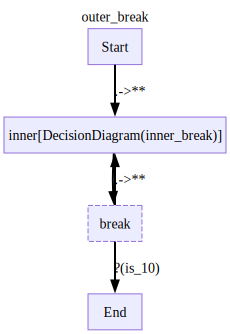

In [ ]:
def is_3(x):
    return x['content'] == 3

def is_10(x):
    return x['content'] == 10

with Define('inner_break') as InnerD:
    V('add',MessageAdder(0),inputs=['Start(**)'],outputs=['break'])
    V('break',is_break=True,outputs=['add(**)',('End',is_3)])
    

with Define('outer_break') as OuterD:
    V('inner',InnerD,inputs=['Start(**)'],outputs=['break'])
    V('break',is_break=True,outputs=['inner(**)',('End',is_10)])


**Expected Behavior:**
* We enter the inner diagram and remain there until we receive a message with content=3
* When we receive a 3, we exit the inner diagram and hit the break in the outer diagram
* The outer diagram will only terminate when we receive a message with content=10
* To completely exit both diagrams, we need a sequence where:
  * First a message with content=3 (to exit the inner diagram)
  * Then a message with content=10 (to exit the outer diagram)


In [ ]:
inputs = [
    {'role':'human','content':0},
    {'role':'human','content':1},
    {'role':'human','content':2},
    {'role':'human','content':3}, # exit inner the first time
    {'role':'human','content':5}, # go to outer and then to inner again
    {'role':'human','content':10}, # 10 wont get us out of the inner diagram
    {'role':'human','content':3}, # exit inner the second time
    {'role':'human','content':10}, # 10 will get us out of the outer diagram
]
outer_d = OuterD()

while True:
    for trace in outer_d.run(input=inputs.pop(0)):
        #print(f'{trace.node_name[0]:<16} == {trace.input_}')
        trace.pprint(skip_passthrough=True) # we use passthrough=True to skip the nodes that only pass the information through and dont' change it
    if outer_d.finished:
        break

assert outer_d.output == {'role': 'human', 'content': 10}

Node inner.add:
{ 'input': {'content': 0, 'role': 'human'},
  'output': {'content': 0, 'role': 'adder'}}
Node inner:
{ 'input': {'content': 0, 'role': 'human'},
  'output': {'content': 0, 'role': 'adder'}}
Node inner.add:
{ 'input': {'content': 1, 'role': 'human'},
  'output': {'content': 1, 'role': 'adder'}}
Node inner:
{ 'input': {'content': 1, 'role': 'human'},
  'output': {'content': 1, 'role': 'adder'}}
Node inner.add:
{ 'input': {'content': 2, 'role': 'human'},
  'output': {'content': 2, 'role': 'adder'}}
Node inner:
{ 'input': {'content': 2, 'role': 'human'},
  'output': {'content': 2, 'role': 'adder'}}
Node inner:
{ 'input': {'content': 3, 'role': 'human'},
  'output': {'content': 3, 'role': 'human'}}
Node inner.add:
{ 'input': {'content': 5, 'role': 'human'},
  'output': {'content': 5, 'role': 'adder'}}
Node inner:
{ 'input': {'content': 5, 'role': 'human'},
  'output': {'content': 5, 'role': 'adder'}}


# States
* States are used to save and return a variable, we can use them to pass data between nodes without creating direct connections in your flow.
* An edge from the State node to another node, used for either setting or getting part of the state is called a state edge.


## Default states
Key points about default states:

- **Writing to state**:  
  Use `E('node->state/key')` to save a node's output to state with key `key`.  

- **Reading from state**:
  Use `E('state/key->node(port=.)')` to read from state.

- **No special setup needed**:
  Default states work out of the box without any configuration.

- **Values persist throughout diagram execution**:
  Each diagram instance maintains its own separate state.



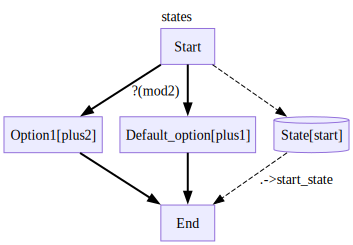

In [ ]:
def plus1(x):
    return x+1

def plus2(x):
    return x+2


# with checkLogs(name='stringdale.diagrams.validate'):
with Define('states') as StateD:
    V('Option1',plus2)
    V('Default_option',plus1)
    E('Start->Option1',cond=mod2)
    E('Start->Default_option')
    E('Default_option->End')
    E('Option1->End')

    E('Start->state/start')
    E('state/start->End(start_state=.)')


In [ ]:
d = StateD()
print('Running with input 1:')
for trace in d.run(1):
    trace.pprint()
print('Running with input 2:')
for trace in d.run(2):
    trace.pprint()
    

Running with input 1:
Node Start:
{'input': {0: 1}, 'output': 1}
Node Default_option:
{'input': {0: 1}, 'output': 2}
Node End:
{'input': {0: 2, 'start_state': 1}, 'output': {0: 2, 'start_state': 1}}
Running with input 2:
Node Start:
{'input': {0: 2}, 'output': 2}
Node Option1:
{'input': {0: 2}, 'output': 4}
Node End:
{'input': {0: 4, 'start_state': 2}, 'output': {0: 4, 'start_state': 2}}


If we don't pass the state input from another node we need to initialize it on run


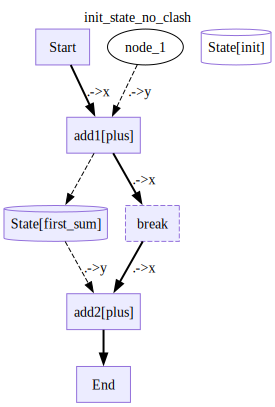

In [ ]:
def plus(x,y):
    return x+y

with Define('init_state_no_clash') as NoClash:
    
    V('add1',plus,
        inputs=['Start(x)','State/init(y)'],
        outputs=['State/first_sum']
        )

    V('break',is_break=True,inputs=['add1(x)'])

    V('add2',plus,
        inputs=['break(x)','State/first_sum(y)'],
        outputs=['End']
        )
    

If we don't initialize the state on run, we get an error.

In [ ]:

d = NoClash()
try:
    for trace in d.run(input=10):
        trace.pprint()
except AttributeError as e:
    print(f"Error: {e}")

Node Start:
{'input': {0: 10}, 'output': 10}
Error: When getting state key 'init' from state BaseModelExtra():

Original error: 'BaseModelExtra' object has no attribute 'init'


In [ ]:
inputs = [
    10,
    100
]

outputs = []
d=NoClash()
while True:
    # note that here the init state is preserved between runs
    for trace in d.run(input=inputs.pop(0),state={'init':1000}):
        trace.pprint()
    outputs.append(d.output)
    if d.finished:
        break

assert outputs == [1010,1110],outputs


Node Start:
{'input': {0: 10}, 'output': 10}
Node add1:
{'input': {'x': 10, 'y': 1000}, 'output': 1010}
Node break:
{'input': {0: 100}, 'output': 100}
Node add2:
{'input': {'x': 100, 'y': 1010}, 'output': 1110}
Node End:
{'input': {0: 1110}, 'output': 1110}


## Custom states
Custom states provide a way to implement more sophisticated state management behavior in your diagrams. They are implemented using Pydantic BaseModel classes.

Let's see an example of a history of values custom state.

In [ ]:
from stringdale.core import NamedLambda
from pydantic import BaseModel,ConfigDict,computed_field

def plus1(x):
    return x+1

# a custom state is any basemodel
class CustomState(BaseModel):
    # we can allow arbitrary attributes by setting extra='allow'
    # this is useful for defining on the fly state keys with normal behavior
    model_config = ConfigDict(extra='allow')
    # Define typed fields with default values
    history:list[int] = list()

    # Custom methods to manipulate state
    def save(self,value):
        self.history.append(value)

State Operations:
* Read from state using State/key->node(port=.)
* Write to state using node->State/key
* Custom operations through defined methods like save()

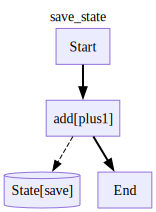

In [ ]:
with Define('save_state',state=CustomState) as D:
    V('add',plus1)

    E('Start->add')
    E('add->End')
    E('add->State/save') 

# TODO - not sure what those mean and where to put them
# we can customize the state behaviour of a given state key by using the State function
# set_append=True means that the state value will be appended to the list of values for the given key
# we can also add custom getters and setters to a state key for more complex state behaviour
# getter is a function of the form (value)->(processed_value)
# setter is a function of the form (old_value,new_value)->(processed_value)

Here is another example of a custom state. Several nodes writing to State/history to maintain a record of values.

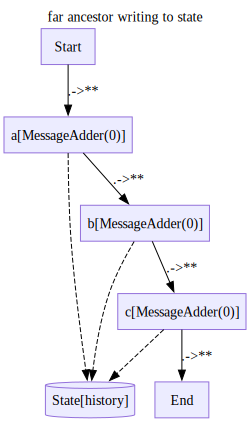

In [ ]:
from itertools import pairwise
from typing import Any,Annotated
class CustomState(BaseModel):
    model_config = ConfigDict(extra='allow')

    history: Annotated[list[Any],list.append] = list()

with Define('far ancestor writing to state',type='flow',state=CustomState) as D:
    a = MessageAdder(0)

    for u in ['a','b','c']:
        V(u,a)
        E(f'{u}->state/history')

    for u,v in pairwise(['Start','a','b','c','End']):
        E(f'{u}->{v}(**)')

# Combination of Flow and Decision Diagrams

stringdale supports combining flow and decision diagrams within a single diagram, allowing you to leverage both parallel processing and conditional branching. However, there are important rules to follow:

1. While you can mix flow and decision parts in the same diagram, you must keep them separated - a node's incoming edges must be either all conditional or all parallel, never mixed.
2. The same rule applies to outgoing edges - they must be either all conditional or all parallel.

This separation ensures clear and predictable behavior while still allowing you to build sophisticated workflows that combine both paradigms.


In [ ]:
def MessageSum(**kwargs):
    sum = 0
    for key,value in kwargs.items():
        count = value['content']
        if isinstance(count,int):
            sum+=count
    return {'role':'sum','content':sum}

We can include decision diagrams as nodes in a flow diagram

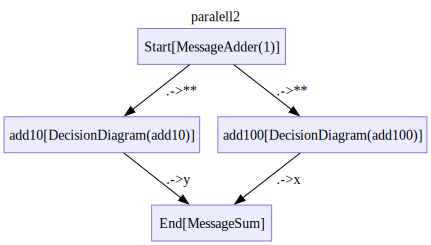

In [ ]:
with Define('add5',draw=False) as Add5:
    V('add',MessageAdder(5),inputs=['Start(**)'],outputs=['End(**)'])

with Define('add10',draw=False) as Add10:
    V('add_first',Add5)
    V('add_second',Add5)
    E('Start->add_first(**)')
    E('add_first->add_second(**)')
    E('add_second->End(**)')

       
with Define('add100',draw=False) as Add100:
    V('add',MessageAdder(100),inputs=['Start(**)'],outputs=['End(**)'])

with Define('paralell2',type='flow') as Parallel2:

    def is112(x):
        return x['content'] == 112

    V('Start',MessageAdder(1))

    V('add10',Add10,inputs=['Start(**)'])
    V('add100',Add100,inputs=['Start(**)'])
    V('End',MessageSum,inputs=['add10(y)','add100(x)'])




We can use Scope to define a flow subdiagram inside a decision diagram (or otherwise)
Here the flow sub diagram is defined inside the decision diagram.

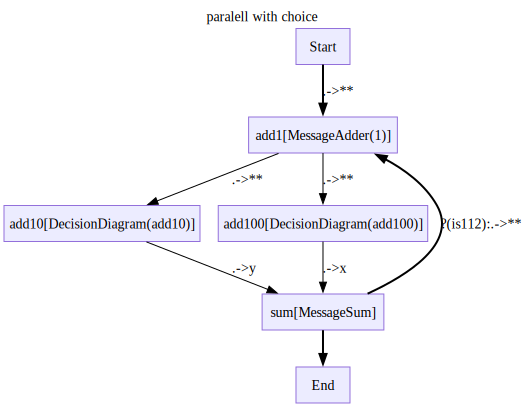

In [ ]:
with Define('paralell with choice') as D:

    def is112(x):
        return x['content'] == 112

    V('add1',MessageAdder(1),inputs=['Start(**)'])
    with Scope('flow'):
        V('add10',Add10,inputs=['add1(**)'])
        V('add100',Add100,inputs=['add1(**)'])
        V('sum',MessageSum,inputs=['add10(y)','add100(x)'])


    E('sum->End')
    E('sum->add1(**)',cond=is112)

    #EXPLAIN what are legal parallel cut

Or we can explicitly define the edge types

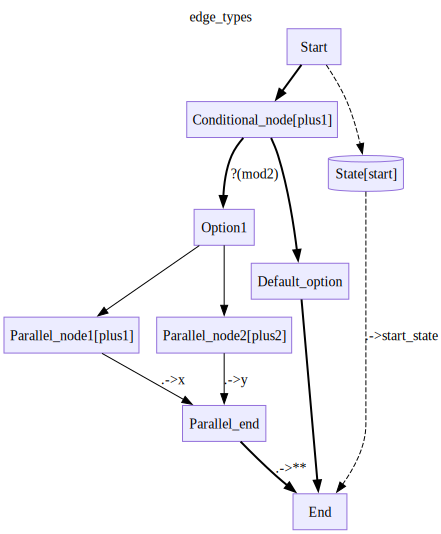

In [ ]:

with Define('edge_types') as EdgeTypes:
    V('Conditional_node',plus1)
    E('Start->Conditional_node')
    V('Option1')
    V('Default_option')
    E('Conditional_node->Option1',cond=mod2)
    E('Conditional_node->Default_option')
    # we can also define a parallel edge by passing scope='flow' to the E function
    V('Parallel_node1',plus1)
    V('Parallel_node2',plus2)
    E('Option1->Parallel_node1',type='flow')
    E('Option1->Parallel_node2',type='flow')
    E('Parallel_node1->Parallel_end(x=.)',type='flow')
    E('Parallel_node2->Parallel_end(y=.)',type='flow')
    E('Parallel_end->End(**)')
    E('Default_option->End')
    

    E('Start->state/start')
    E('state/start->End(start_state=.)')


d = EdgeTypes()



# Batching

* For_each with stream and non stream (what it even means?) - stream is treating each element as a separate input, non stream is treating the whole list as a single input, right?
* Nested diagrams in foreach? what's the meaning? TODO


Some functions that we'll need for the batching examples.

MakeItems is a class that creates a list of items based on a starting value.
* num_items: determines how many items to generate
* delta: the increment between each item
* sleep: adds a delay to simulate processing time
* When called with a value x, it returns a list [x, x+delta, x+2*delta, ..., x+(num_items-1)*delta]

MakeItemsAsync is the asynchronous version of the same functionality.


In [ ]:
import time
import asyncio

class MakeItems:
    def __init__(self,num_items,delta,sleep):
        self.num_items = num_items
        self.delta = delta
        self.sleep = sleep
    def __call__(self,x):
        time.sleep(self.sleep)
        return [x+i*self.delta for i in range(self.num_items)]

    def __str__(self):
        return f'MakeItems(num_items={self.num_items},delta={self.delta},sleep={self.sleep})'

class MakeItemsAsync:
    def __init__(self,num_items,delta,sleep):
        self.num_items = num_items
        self.delta = delta
        self.sleep = sleep
    async def __call__(self,x):
        await asyncio.sleep(self.sleep)
        return [x+i*self.delta for i in range(self.num_items)]
    def __str__(self):
        return f'MakeItemsAsync(num_items={self.num_items},delta={self.delta},sleep={self.sleep})'


def sum_all(*arr):
    return sum(arr)

def add_to_arr(arr,x):
    return [a+x for a in arr]

def plus(x,y):
    return x+y

def sort(arr):
    return sorted(arr)

async def asort(arr):
    return sorted(arr)

def concat(arr1,arr2):
    return arr1+arr2


## Basic Batch Processing
The simplest form of batch processing uses the for_each parameter to iterate over lists of items:

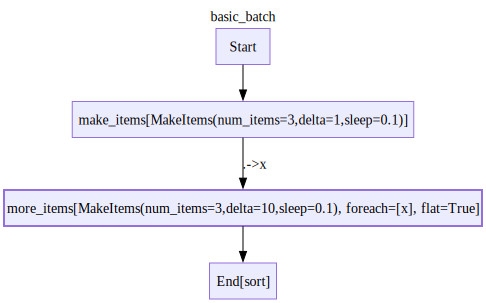

In [ ]:
with Define('basic_batch', type='flow') as D:
    V('make_items', MakeItems(3, delta=1, sleep=0.1), inputs=['Start'])
    V('more_items', MakeItems(3, delta=10, sleep=0.1),
        for_each=['x'],  # Iterate over each item in the input
        inputs=['make_items(x)'],
        outputs=['End'],
        flat=True  # Flatten the resulting nested lists
    )
    V('End', sort)


In this example:
* make_items generates a list [0, 1, 2]
* more_items processes each number separately, generating [10, 11, 12] for each input
* The flat=True parameter combines all results into a single list
* Finally, the results are sorted

When run with input 0, produces: [0, 1, 2, 10, 11, 12, 20, 21, 22]


In [ ]:
d = D()
for trace in d.run(0):
    trace.pprint()



Node Start:
{'input': {0: 0}, 'output': 0}
Node make_items:
{'input': {0: 0}, 'output': [0, 1, 2]}
Node more_items[0]:
{'input': {'x': 0}, 'output': [0, 10, 20]}
Node more_items[1]:
{'input': {'x': 1}, 'output': [1, 11, 21]}
Node more_items[2]:
{'input': {'x': 2}, 'output': [2, 12, 22]}
Node End:
{ 'input': {0: [0, 10, 20, 1, 11, 21, 2, 12, 22]},
  'output': [0, 1, 2, 10, 11, 12, 20, 21, 22]}


## Cartesian Products
You can process multiple input streams in parallel using for_each with multiple parameters:

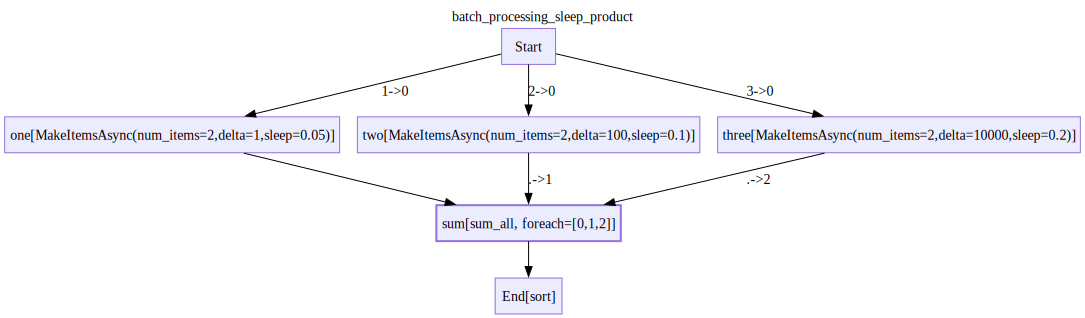

In [ ]:
with Define('batch_processing_sleep_product',type='flow') as D:
    V('one',MakeItemsAsync(2,1,sleep=0.05),inputs=['Start(0=1)'])
    V('two',MakeItemsAsync(2,100,sleep=0.10),inputs=['Start(0=2)'])
    V('three',MakeItemsAsync(2,10000,sleep=0.2),inputs=['Start(0=3)'])
    V('sum',sum_all,inputs=['one(0)','two(1)','three(2)'],for_each=[0,1,2])
    V('End',sort,inputs=['sum'])


In [ ]:
sum_all(1,2,3)

6

In [ ]:
d=D()
for trace in d.run({1:10,2:1000,3:100000}):
    # trace.pprint()
    pass

assert d.output == [101010, 101011, 101110, 101111, 111010, 111011, 111110, 111111]

## Mixing Stream and Non-Stream Inputs
You can combine batch processing with regular inputs:

In [ ]:

# TODO - try to do sub diagram with flat and without flat to see what's happening


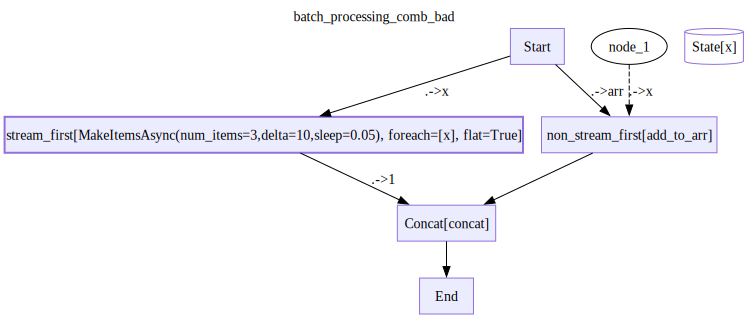

In [ ]:
with Define('batch_processing_comb_bad',type='flow') as D_bad:
    V('non_stream_first',add_to_arr,inputs=['Start(arr)','State/x(x = .)'])
    V('stream_first',MakeItemsAsync(3,10,sleep=0.05),inputs=['Start(x)'],for_each=['x'],flat=True)

    V('Concat',concat,inputs=['non_stream_first(0)','stream_first(1)'])
    V('End',inputs=['Concat'])

In [ ]:
dd = D_bad()
for trace in dd.run([0],state={'x':100,'y':1000}):
    trace.pprint(skip_passthrough=True)

Node non_stream_first:
{'input': {'arr': [0], 'x': 100}, 'output': [100]}
Node stream_first[0]:
{'input': {'x': 0}, 'output': [0, 10, 20]}
Node Concat:
{'input': {0: [100], 1: [0, 10, 20]}, 'output': [100, 0, 10, 20]}


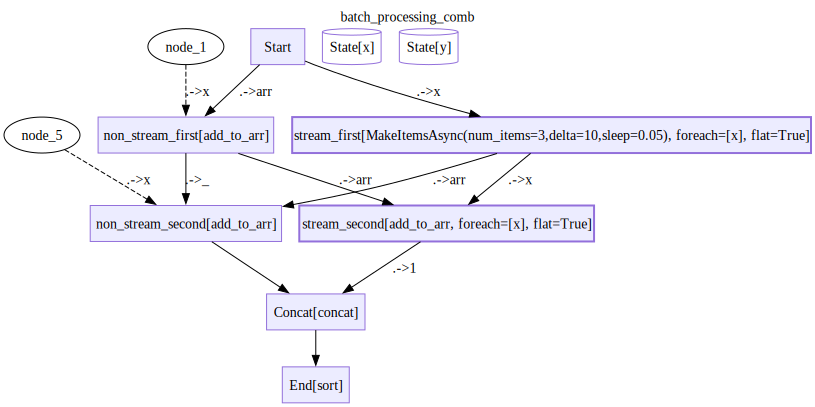

In [ ]:
with Define('batch_processing_comb',type='flow') as D:
    V('non_stream_first',add_to_arr,inputs=['Start(arr)','State/x(x = .)'])
    V('stream_first',MakeItemsAsync(3,10,sleep=0.05),inputs=['Start(x)'],for_each=['x'],flat=True)

    V('non_stream_second',add_to_arr,inputs=['non_stream_first(_)','stream_first(arr)','State/y(x = .)'])
    V('stream_second',add_to_arr,inputs=['stream_first(x)','non_stream_first(arr)'],for_each=['x'],flat=True)

    V('Concat',concat,inputs=['non_stream_second(0)','stream_second(1)'])
    V('End',sort,inputs=['Concat'])

In [ ]:
# with checkLogs(name='stringdale.diagrams.flow'):
d=D()
for trace in d.run([0],state={'x':100,'y':1000}):
    trace.pprint(skip_passthrough=True)


Node non_stream_first:
{'input': {'arr': [0], 'x': 100}, 'output': [100]}
Node stream_first[0]:
{'input': {'x': 0}, 'output': [0, 10, 20]}
Node non_stream_second:
{'input': {'arr': [0, 10, 20], 'x': 1000}, 'output': [1000, 1010, 1020]}
Node stream_second[2]:
{'input': {'arr': [100], 'x': 20}, 'output': [120]}
Node stream_second[0]:
{'input': {'arr': [100], 'x': 0}, 'output': [100]}
Node stream_second[1]:
{'input': {'arr': [100], 'x': 10}, 'output': [110]}
Node Concat:
{ 'input': {0: [1000, 1010, 1020], 1: [120, 100, 110]},
  'output': [1000, 1010, 1020, 120, 100, 110]}
Node End:
{ 'input': {0: [1000, 1010, 1020, 120, 100, 110]},
  'output': [100, 110, 120, 1000, 1010, 1020]}


## Nested Diagrams in Batch Processing
You can even use entire diagrams as batch processors:

In [ ]:
async def add_sleep(x):
    await asyncio.sleep(0.1)
    return x+1


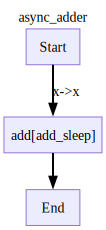

In [ ]:
with Define('async_adder')as AsyncAdd:
    V('add',add_sleep,inputs=['Start(x=x)'],outputs=['End'])

async_add=AsyncAdd()
for trace in async_add.run({'x':0}):
    pass


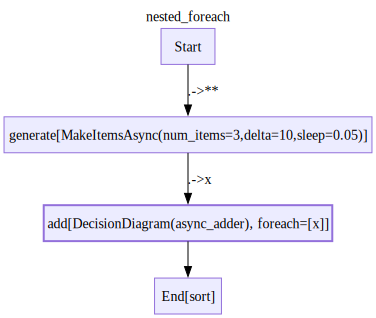

In [ ]:
with Define('nested_foreach',type='flow') as D:
    V('generate',MakeItemsAsync(3,10,sleep=0.05),inputs=['Start(**)'])
    V('add',AsyncAdd,inputs=['generate(x=.)'],for_each=['x'])
    V('End',sort,inputs=['add'])


In [ ]:
d=D()
for trace in d.run({'x':0}):
    trace.pprint(skip_passthrough=True)

Node generate:
{'input': {'x': 0}, 'output': [0, 10, 20]}
Node add[1].add:
{'input': {'x': 10}, 'output': 11}
Node add[0].add:
{'input': {'x': 0}, 'output': 1}
Node add[2].add:
{'input': {'x': 20}, 'output': 21}
Node add[1]:
{'input': {'x': 10}, 'output': 11}
Node add[2]:
{'input': {'x': 20}, 'output': 21}
Node add[0]:
{'input': {'x': 0}, 'output': 1}
Node End:
{'input': {0: [11, 21, 1]}, 'output': [1, 11, 21]}


## Real-World Example: Text Processing
Here's a practical example of batch processing for text analysis:


In [ ]:
sample_doc = {'text':"""
The elephant is one of the most remarkable creatures on Earth. Known for their intelligence and complex social structures, elephants form deep family bonds that can last a lifetime. These gentle giants possess remarkable memory capabilities and demonstrate emotional behaviors like mourning their dead. Their distinctive trunks, containing over 40,000 muscles, serve multiple purposes from gathering food to expressing affection.

The arctic fox is a fascinating animal that has adapted perfectly to life in the extreme cold. During winter, its thick white fur provides both insulation and camouflage in the snowy landscape, while in summer its coat turns brownish-gray to blend with the tundra. These resourceful predators can survive temperatures as low as -50°C (-58°F) and will travel vast distances across the Arctic ice in search of food, often following polar bears to scavenge their leftovers.

The octopus stands out as one of the ocean's most intelligent invertebrates. With nine brains (one central brain and eight additional ones in each arm), these cephalopods can solve complex puzzles, open jars, and even use tools. Their remarkable ability to change both color and texture allows them to perfectly mimic their surroundings, making them masters of disguise. Despite their impressive capabilities, most octopus species live only 1-2 years, making their intelligence even more remarkable given their short lifespan.
""",
'id':'animal_book'
}


def splitter(doc):
    doc_id = doc['id']
    text = doc['text']
    return [{'text':chunk.strip(),'id':f'{doc_id}_{i}'} for i,chunk in enumerate(text.split('\n\n'))]


def summarizer(text):
    return text[:20]


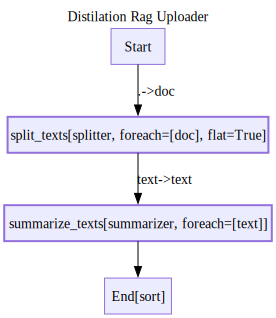

In [ ]:
with Define('Distilation Rag Uploader',type='flow') as D:
    V('split_texts',splitter,inputs=['Start(doc=.)'],for_each=['doc'],flat=True)
    V('summarize_texts',summarizer,inputs=['split_texts(text=text)'],for_each=['text'])
    V('End',sort,inputs=['summarize_texts'])

This pipeline:
* Takes a document and splits it into chunks
* Processes each chunk independently
* Combines and sorts the results



In [ ]:
d = D()
for trace in d.run([sample_doc]):
    #trace.pprint()
    pass

assert d.output == ['The arctic fox is a ', 'The elephant is one ', 'The octopus stands o'],d.output

# Stateful nodes and Serialization